In [1]:
from PIL import Image
from easy_dwpose import DWposeDetector
# from controlnet_aux import DWposeDetector

import torchvision.transforms as transforms
import torch
import numpy as np

In [ ]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('../../external'))
from PCDMs.src.controlnet_aux import OpenposeDetector


/home/aliaagheis/projects/Ad-Image-Generation/external/PCDMs/src/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with PCDMs.src.controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/aliaagheis/projects/Ad-Image-Generation/external/PCDMs/src/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with PCDMs.src.controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/aliaagheis/projects/Ad-Image-Generation/external/PCDMs/src/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_21m_224

In [58]:
# s_img = Image.open("../../datasets/fashion/test_lst_256_png/test_lst_256_png/WOMEN_Cardigans_id_00006266_01_1_front.png")
s_img = Image.open("WOMEN_Cardigans_id_00006266_01_1_front.jpeg")

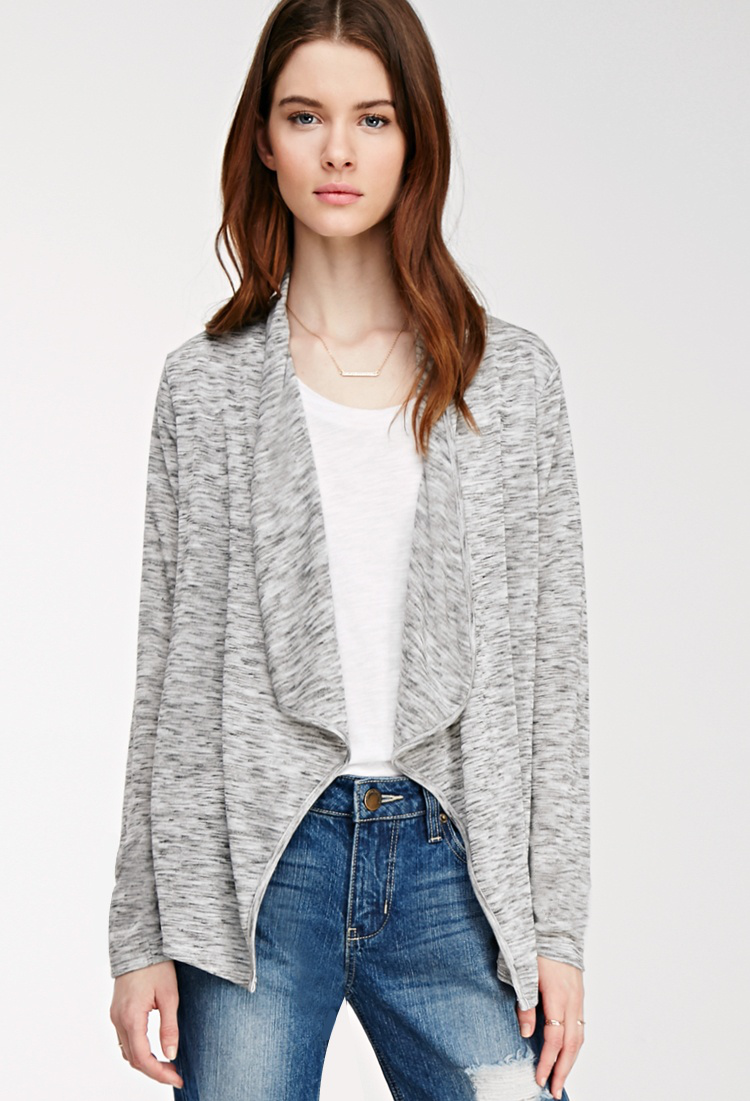

In [59]:
s_img

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(device)


/home/aliaagheis/projects/Ad-Image-Generation/external/PCDMs/src/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfe

In [78]:
import cv2
from PCDMs.src.controlnet_aux import *

def HWC3(x):
    assert x.dtype == np.uint8
    if x.ndim == 2:
        x = x[:, :, None]
    assert x.ndim == 3
    H, W, C = x.shape
    assert C == 1 or C == 3 or C == 4
    if C == 3:
        return x
    if C == 1:
        return np.concatenate([x, x, x], axis=2)
    if C == 4:
        color = x[:, :, 0:3].astype(np.float32)
        alpha = x[:, :, 3:4].astype(np.float32) / 255.0
        y = color * alpha + 255.0 * (1.0 - alpha)
        y = y.clip(0, 255).astype(np.uint8)
        return y

def resize_image(input_image, resolution):
    H, W, C = input_image.shape
    H = float(H)
    W = float(W)
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(np.round(H / 64.0)) * 64
    W = int(np.round(W / 64.0)) * 64
    img = cv2.resize(input_image, (W, H), interpolation=cv2.INTER_LANCZOS4 if k > 1 else cv2.INTER_AREA)
    return img


def detect_poses(openpose, oriImg):
        oriImg = oriImg[:, :, ::-1].copy()
        H, W, C = oriImg.shape
        with torch.no_grad():
            candidate, subset = openpose.body_estimation(oriImg)
            
            bodies = openpose.body_estimation.format_body_result(candidate, subset)

            results = []
            for body in bodies:
                results = [(keypoint.x, keypoint.y)  if keypoint is not None else None for keypoint in body.keypoints]
            
            return results

def get_poses(openpose, input_image, detect_resolution=512, image_resolution=512, include_body=True, include_hand=False, include_face=False, hand_and_face=None):
    if not isinstance(input_image, np.ndarray):
        input_image = np.array(input_image, dtype=np.uint8)

    input_image = HWC3(input_image)
    input_image = resize_image(input_image, detect_resolution)
    H, W, C = input_image.shape
    
    poses = detect_poses(openpose, input_image)
    return poses

In [79]:
poses = get_poses(openpose, s_img, detect_resolution=256, image_resolution=256)

In [80]:
poses

[(np.float64(116.0), np.float64(51.0)),
 (np.float64(122.0), np.float64(130.0)),
 (np.float64(68.0), np.float64(132.0)),
 (np.float64(58.0), np.float64(233.0)),
 (np.float64(46.0), np.float64(324.0)),
 (np.float64(174.0), np.float64(128.0)),
 (np.float64(187.0), np.float64(229.0)),
 (np.float64(190.0), np.float64(326.0)),
 (np.float64(86.0), np.float64(301.0)),
 None,
 None,
 (np.float64(150.0), np.float64(299.0)),
 (np.float64(172.0), np.float64(383.0)),
 None,
 (np.float64(105.0), np.float64(39.0)),
 (np.float64(128.0), np.float64(40.0)),
 (np.float64(89.0), np.float64(49.0)),
 (np.float64(143.0), np.float64(50.0))]

In [66]:
arr = np.array([   
          [0.3095, -0.6705 ],
          [0.3621, -0.0177 ],
          [-0.2691,  0.0078], 
          [-0.3919, 0.8654 ],
          [-0.5321,  1.6461],  
          [0.9932, -0.0177 ], 
          [1.1335,  0.8654],
          [1.2036,  1.6845 ],
          [-0.0763,  1.4669], 
          [-1.8120, -1.1185], 
          [-1.8120, -1.1185],  
          [0.7303,  1.4669 ],
          [-1.8120, -1.1185], 
          [-1.8120, -1.1185],
          [0.1867, -0.7601 ], 
          [0.4497, -0.7601 ],
          [-0.0061, -0.6833], 
          [0.6075, -0.6833] ])


pose = dict(
            bodies=arr,
            body_scores=np.ones(18),
            hands=np.array([]),
            hands_scores=np.array([]),
            faces=np.array([]),
            faces_scores=np.array([]),
        )


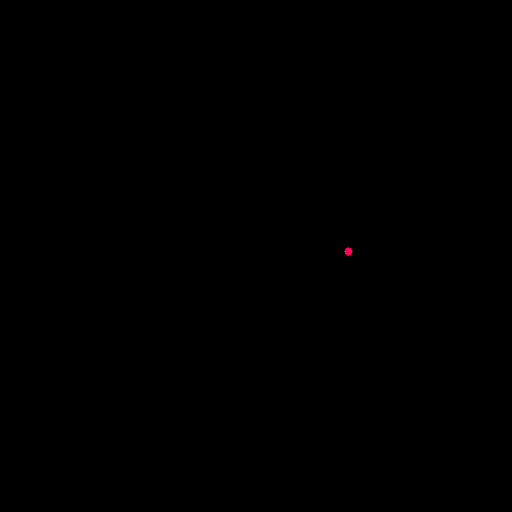

In [78]:
# %debug
from easy_dwpose.draw.openpose import draw_bodypose


canvas = np.zeros(shape=(height, width, 3), dtype=np.uint8)

Image.fromarray(draw_bodypose(canvas, arr*0.5+0.5, np.ones_like(scores)))

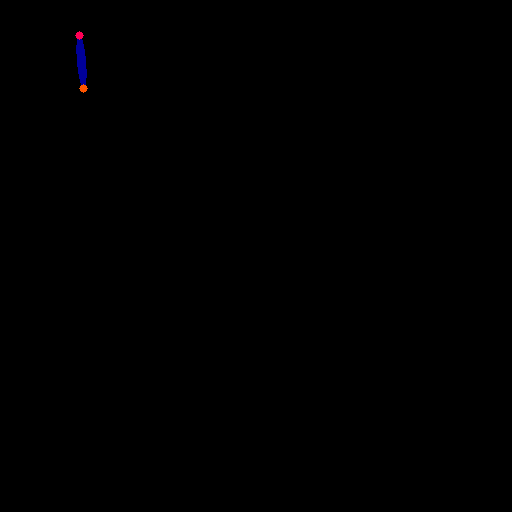

In [89]:
canvas = np.zeros(shape=(height, width, 3), dtype=np.uint8)

Image.fromarray(draw_bodypose(canvas, bodies, scores))